# CODE: Evaluation of the Measurement Uncertainty in Ligand Binding Assays with Focus on Mobility Shift Affinity Capillary Electrophoresis

## Code Evaluation of simulated data

This Notebook was used to evaluate and present the data of the Monte Carlo Simulations.

Version: 0.1.22
Author: Matthias Oliver Stein

Mail I: matthias.stein@tu-braunschweig.de
Mail II: stein.matthiasoliver@gmail.com

# 1. Import of important packages

In [7]:
import os

import numpy as np
import scipy as sc
from scipy import stats
from scipy.stats import t
import pandas as pd

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, KFold

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.ticker import LinearLocator, FormatStrFormatter, MaxNLocator

import datetime as dt

# 2. Definition of functions

In [8]:


def norm_data(data_array,norm_type='1'):
    '''
    Normalization of data
        Inputs:
        data_array = list or numpy_array of data that has to be normalized.
        norm_type = definition of the type of normalization, 
            '1': Normalization of data to the range -1 to 1.
            '0': Normalization of data to the range 0 to 1.
    Return:
        list of normalized data
    '''
    norm_data = [(2*(x - np.amin(data_array)))/(np.amax(data_array) - np.amin(data_array))-1  for x in data_array]
    if norm_type == '0':
        norm_data = [((x - np.amin(data_array)))/(np.amax(data_array) - np.amin(data_array))  for x in data_array]
    return norm_data


      

def back_to_normal(x_transformed, lambda_boxcox):
    '''
    transforms box-cox-transformed data back in its normal form.
    Inputs:
        x_transformed: Box-Cox transformed data as float
        lambda_boxcox: corresponding Box-Cox-transformation parameter as float
    Return:
        x: the back transformed version of x_transformed as float
    '''
    if lambda_boxcox == 0:
        x_norm = np.exp(x_transformed)
    else:
        x_norm = (x_transformed*lambda_boxcox+1)**(1/lambda_boxcox)
    return x_norm


def plot_metrics(vals_shuffle, opt_deriv_sh, ylabel,
                 objective,xticks_in,title,savename=None,show_plot = True,p=0.75):
    '''
    Calculation of the optimal number of PLS components, graphical representation
    Inputs
        vals_shuffle: list of quality parameter in component selection, e.g., MSE valu
        opt_deriv_sh: list of numerical derivative values 
        y_label: y-label in the plot as string
        objective: definition of the optimal value, 'min' or 'max'
        xticks_in: x_ticks for the plot, normally the number of components tested as list
        title: title of the plot as string
        savename: bool and string, if None no save, if string save using that str as file name, e.g., 'MSE_plot.png'
        show_plot: bool to display the plot
        p: percentage of max comp
    Return:
        [0] xticks_in[idx_s]: optimal number of PLS components
        [1] Figure: Figure object
    Ref:
        Adatped from the tutorial on: https://www.kaggle.com/phamvanvung/partial-least-squares-regression-in-python
        Author: Vung Pham Assistant Professor, Department of Computer Science, Sam Houston State University, Texas, USA
        The Tutorial Notebook has been released under the Apache 2.0 open source license.
        This Tutorial was related to the blog: https://nirpyresearch.com/partial-least-squares-regression-python/
        The NIRPY Research Blog by Daniel Pelliccia is licensed under a 
        Creative Commons Attribution 4.0 International License.
    '''
    x_max = np.max(xticks_in)
    x_max_p = p * x_max
    Figure, ax = plt.subplots()
    with plt.style.context('ggplot'):
        plt.plot(xticks_in, np.array(vals_shuffle), '--o', color='red', mfc='red',label='shuffled')
        if objective=='min':
            idx_s = np.argmin(vals_shuffle)
            if idx_s >= x_max_p:
                idx_s = opt_deriv_sh-1
        else:
            idx_s = np.argmax(vals_shuffle)
            if idx_s >= x_max_p:
                idx_s = opt_deriv_sh-1
        plt.plot(xticks_in[idx_s], np.array(vals_shuffle)[idx_s], 'X', ms=10, mfc='blue')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('Number of PLS components')
        plt.ylabel(ylabel)
        plt.legend()
        plt.title(title)
    if savename:
        plt.savefig(savename)
    if show_plot:
        plt.show()
    else: 
        plt.close()
    
    return xticks_in[idx_s], Figure
    
def PLS_quality_no_components(X_matrix, Y_vector, no_comp, cross_val_sets = 5,shuffle_in=True):
    '''
    Calculation of the optimal number of PLS components, 
    Cross-validation with a defined number of splits and quality measure
    Inputs:
        X_matrix: descriptor matrix as array
        Y_vector: response matrix (or vector) as array
        no_comp: number of PLS components to test as int
        cross_val_sets: number of k-fold splits as int
        shuffle_in: bool to shuffle to data set or not
    Return:
        [0] y_pred_cross_val: cross-val predicted Y data set as array
        [1] r2_score_value: R^2 value for the cross validation
        [2] MSE: mean squared error of prediction
        [3] Residual Prediction Deviation SD(y)/RMSEP
    Ref:
        Adatped from the tutorial on: https://www.kaggle.com/phamvanvung/partial-least-squares-regression-in-python
        Author: Vung Pham Assistant Professor, Department of Computer Science, Sam Houston State University, Texas, USA
        The Tutorial Notebook has been released under the Apache 2.0 open source license.
        This Tutorial was related to the blog: https://nirpyresearch.com/partial-least-squares-regression-python/
        The NIRPY Research Blog by Daniel Pelliccia is licensed under a 
        Creative Commons Attribution 4.0 International License.
    '''
    init_PLS = PLSRegression(n_components=no_comp)
    kf = KFold(n_splits=cross_val_sets,shuffle=shuffle_in)
    splits = kf.split(X_matrix)
    y_pred_cross_val = cross_val_predict(init_PLS,X_matrix,Y_vector,cv = splits)
    r2_score_value = r2_score(Y_vector,y_pred_cross_val)
    MSE = mean_squared_error(Y_vector,y_pred_cross_val)
    RPD = Y_vector.std()/ np.sqrt(MSE)
    
    return y_pred_cross_val,r2_score_value,MSE,RPD


def predict_Response(Value_list, PLS_reg_func,lambda_boxcox,drop_coef_list):
    '''
    Function for the prediction of quality parameter as a function of defined inputs.   
    Inputs:
       Value_list: list of single predictor variables. must match the order in drop_coef_list
       PLS_reg_func: PLS regression object, trained with box-cox-transformed Y
       lambda_boxcox: Box-Cox value of the transformed variables as float
       drop_coef_list: list of coefficients to be dropped as list of bool
    Return:
        [0] out: predicted value as float
    '''
    # generate full design matrix X
    X_i = Value_list.copy()
    for k in range(len(Value_list)):
        sqr = (Value_list[k])**2
        X_i.append(sqr)
        for l in range(k+1,len(Value_list)):
            inter = Value_list[k] * (Value_list[l])
            X_i.append(inter)
    col_list = []
    for i in range(len(drop_coef_list)):
        if drop_coef_list[i]:
            col_list.append(i)
    # Drop x-values from X when not included
    X_i_mat_pre =  np.array([X_i])
    X_i_mat = np.delete(X_i_mat_pre,col_list,1)
    Reg_model = PLS_reg_func.predict(X_i_mat)
    # Transform prediction from box-cox-transformed version back to its normal space
    out = back_to_normal(Reg_model[0], lambda_boxcox)
    
    return out[0]
    

def VIP_function(PLS_model):
    '''
    Input:
        PLS_model: sklearn PLS object
    return:
        VIP_values: vip scores for every variable as array
    Ref: 
    Adaption of MatLab function according to: 
    https://www.sciencedirect.com/science/article/abs/pii/S0169743912001542. 
    The MATLAB code is available under a BSD License.
    Copyright (c) 2014, Hongdong Li, All rights reserved.
    BSD License: https://www.mathworks.com/matlabcentral/fileexchange/view_license?file_info_id=47767
    The function was translated to python code by Martin Fitzpatrick
    https://github.com/scikit-learn/scikit-learn/issues/7050
    '''
    x_scores = PLS_model.x_scores_
    x_weights = PLS_model.x_weights_
    y_loadings = PLS_model.y_loadings_
    number_of_variables, number_of_components = x_weights.shape
    VIP_values = np.zeros((number_of_variables,))
    s = np.diag(x_scores.T @ x_scores @ y_loadings.T @ y_loadings).reshape(number_of_components, -1)
    total_s = np.sum(s)
    for variable_i in range(number_of_variables):
        weight_variable_i = np.array([(x_weights[variable_i,component_j] / np.linalg.norm(x_weights[:,component_j]))**2 for component_j in range(number_of_components)])
        VIP_values[variable_i] = np.sqrt(number_of_variables*(s.T @ weight_variable_i)/total_s)
    return VIP_values


def Stats_Model(Y,Reg_model,  X_matrix, PLS_model, savename=None):
    '''
    Function for graphical respresentation of model quality.
    Input:
        Y: response data as array
        Reg_model: predicted response data as array
        X_matrix: predictor matrix as array
        PLS_model: sklearn PLS object
        savename: file name as string
    '''
    alpha_plots = 0.03
    Residuals = [float(x-y) for x,y in zip (Y,Reg_model)]
    plt.figure(figsize=(8,8))
    plt.subplot(221)
    plt.plot(Y,Reg_model,'.',color='blue',alpha=alpha_plots)
    min_y,max_y = np.amin(Y),np.amax(Y)
    R_2_pred_vs_meas = r2_score(Y,Reg_model)
    y_pred_cross_val = cross_val_predict(PLS_model,X_matrix,Y,cv = 5)
    r2_score_value = r2_score(Y,y_pred_cross_val)
    plt.plot([min_y*0.9,max_y*1.1],[min_y*0.9,max_y*1.1],'r-',
             label= '$R^2: $' + f'{round(R_2_pred_vs_meas,3)}'+'\n$R^2_{CV}: $' + f'{round(r2_score_value,3)} ')
    plt.xlabel('Y')
    plt.ylabel('predicted Y')
    plt.title('Correlation')
    plt.legend()
    plt.subplot(222)
    plt.plot(Residuals,'.',color='blue',alpha=alpha_plots)
    plt.plot([0,len(Residuals)],[0,0],'r-')
    plt.xlabel('no observation')
    plt.ylabel('Residuals')
    plt.title('Residuals at observation')
    plt.subplot(223)
    plt.plot(Reg_model,Residuals,'.',color='blue',alpha=alpha_plots)
    plt.plot([min_y*0.9,max_y*1.1],[0,0],'r-')
    plt.xlabel('predicted Y')
    plt.ylabel('Residuals')
    plt.title('Residuals at predicted Y')
    ax =  plt.subplot(224)
    stats.probplot(Residuals, plot=plt,rvalue=True)
    ax.get_lines()[0].set_marker('.')
    ax.get_lines()[0].set_color('blue')
    ax.get_lines()[0].set_alpha(alpha_plots)
    #ax.get_lines()[0].set_markersize(3.0)
    plt.xlabel('Theoretical quantiles norm')
    plt.ylabel('Residuals')
    plt.title('Probability plot Residuals')
    plt.tight_layout()
    if savename:
        plt.savefig(savename)
        

def find_opt_no_comp(X,Y,Opt_parameter = 'MSE',
                     min_comp_in = None,max_comp_in = None,
                     title_in = 'title_in_2',savename_in = None,
                     splits_in = 5,show_plot_in = True,shuffle_in_2=True,
                     Deriv_threshold= 0.01,p_in= 0.75):
    '''
    Function to find and plot optimal number of PLS components
    Inputs:
        X: descriptor matrix as array
        Y: response matrix as array
        Opt_parameter: optimality parameter
        min_comp_in: manual input of minimal number of components as int
        max_comp_in: manual input of maximal number of components as int
        title_in: title for plot as string
        savename_in: file name as string
        splits_in: number of k splits as int
        show_plot_in: bool to show plot
        shuffle_in_2: bool to shuffle the data in cross validation
        Deriv_threshold: threshold for derivative parameter
        p_in: see plot_metrics
    Return:
        [0] Min_comp_shuf: opt PLS components
        [1] Figure_comp: figure object PLS-comp vs. quality parameter
        [2] Rel_Derivative_sh: list of relative derivative values
        [3] opt_deriv_sh: optimal number of comp derivative
    Ref:
        Includes parts from the tutorial on: 
        https://www.kaggle.com/phamvanvung/partial-least-squares-regression-in-python
        Author: Vung Pham Assistant Professor, Department of Computer Science, 
        Sam Houston State University, Texas, USA
        The Tutorial Notebook has been released under the Apache 2.0 open source license.
        This Tutorial was related to the blog: 
        https://nirpyresearch.com/partial-least-squares-regression-python/
        The NIRPY Research Blog by Daniel Pelliccia is licensed under a 
        Creative Commons Attribution 4.0 International License.
    '''
    
    max_comp = np.linalg.matrix_rank(X, tol=None, hermitian=False) - 1
    min_comp = 1
    if min_comp_in:
        min_comp = min_comp_in
    if max_comp_in:
        max_comp = max_comp_in
    component_list = np.arange(min_comp,max_comp)
    r2_list_shuffle = []
    MSE_list_shuffle = []
    RPD_list_shuffle = []

    for comp_i in component_list:
        __, r2_i_shuffle, MSE_i_shuffle, RPD_i_shuffle = PLS_quality_no_components(X, Y, comp_i, cross_val_sets = splits_in,shuffle_in=shuffle_in_2)
        MSE_list_shuffle.append(MSE_i_shuffle)
        r2_list_shuffle.append(r2_i_shuffle)
        RPD_list_shuffle.append(RPD_i_shuffle)
    if Opt_parameter == 'MSE':
        Deriv_sh_param = MSE_list_shuffle
    elif Opt_parameter == 'r2':
        Deriv_sh_param = r2_list_shuffle
    else:
        Deriv_sh_param = RPD_list_shuffle 
    Rel_Derivative = []
    Derivative_array_sh = np.array([(Deriv_sh_param[x+1] - Deriv_sh_param[x-1])/(component_list[x+1]- component_list[x-1]) for x in range(1,len(component_list)-1)] )
    abs_max_deriv_sh = np.amax([ abs(x) for x in Derivative_array_sh])
    Rel_Derivative_sh = [ abs(x/ abs_max_deriv_sh) for x in Derivative_array_sh]
    opt_deriv_sh = 1
    for Deriv_value in Rel_Derivative_sh:
        if Deriv_value < Deriv_threshold:
            break
        else:
            opt_deriv_sh += 1
        
    if Opt_parameter == 'MSE':
        Min_comp_shuf, Figure_comp = plot_metrics(MSE_list_shuffle, opt_deriv_sh, 'MSE', 'min',component_list,title_in,savename_in,show_plot=show_plot_in,p=p_in)
    elif Opt_parameter == 'r2':
        Min_comp_shuf, Figure_comp = plot_metrics(r2_list_shuffle, opt_deriv_sh, '$r^2$', 'max',component_list,title_in,savename_in,show_plot=show_plot_in,p=p_in)
    else:
        Min_comp_shuf, Figure_comp = plot_metrics(RPD_list_shuffle, opt_deriv_sh, 'RPD', 'max',component_list,title_in,savename_in,show_plot=show_plot_in,p=p_in)
            
    return Min_comp_shuf, Figure_comp ,Rel_Derivative_sh,opt_deriv_sh


def create_c_in(KD,c_min,c_max,no_c,rep,zero_min = -1):
    '''
    Definition of the Log-Lin concentration set
    creates a log-linearly spaced set of concentrations with a defined
    number of entries between a minimum and 
    maximum expressed as multiples of KD
    inputs:
         KD: dissociation constant as float
         c_min: minimal concentration as pos. float
         c_max: maximal concentration as multiples of KD as pos. float
         no_c: number of different cocentrations as int
         rep: number of replicated concentrations as int
         zero_min: default minimum if the real c_min is 0
    return:
        concentration set as numpy array
    '''

    log_max = np.log10(c_max * KD)

    zero_in = []
    no_c_in = no_c
    if c_min ==  0:
        log_min = zero_min
        no_c_in -=1
        zero_in = [0]
    else:
        log_min = 0

    c_in = np.concatenate([np.concatenate([zero_in,np.logspace(log_min,log_max,no_c_in)]) for __ in range(rep)])
    c_in.sort()
    return c_in

def plot_raw_effects(specified_DF,plot_param_list,plot_key_list,
                     suptitle = 'Raw Effects of derived Parameters\n',save_name ='Raw_effects_derived_parameter'):
    '''
    Helper function for graphical representation of raw effects
    Inputs:
        specified_DF: Pandas DataFrame with speficied data
        plot_param_list: list of parameter to plot
        plot_key_list: list of the parameter's keys
        suptitle: string with title of the plot
        save_name = file name without extention
    '''

    alpha_list = ['(a)', '(b)', '(c)','(d)', '(e)', '(f)','(g)', '(h)', '(i)','(j)', '(k)', '(l)',
                  '(m)', '(n)', '(o)','(p)', '(q)', '(r)','(s)', '(t)', '(u)','(v)', '(w)', '(x)', '(y)','(z)']
    
    total_no_plots = int(np.ceil((len(plot_key_list) * len(plot_param_list))/3))
    plt.figure(figsize=(8,8))
    plot_no = 1
    param_name = 0
    for param in plot_param_list:
        key_name = 0
        for key in plot_key_list:
            plt.subplot(total_no_plots,3,plot_no)
            slope, intercept, r, p, se = stats.linregress(specified_DF[key], specified_DF[param])
            fit_values = [intercept + slope * x for x in [-1,1]]
            plt.plot(specified_DF[key],specified_DF[param],'b.',alpha=0.02,label=f'{param} vs. {key}')
            plt.plot([-1,1],fit_values,'r-')
            if not(key == 'rep_norm_m' or key == 'MU_norm'):
                poly_fit_init = np.polyfit(specified_DF[key], specified_DF[param], 2)
                polyfit = np.poly1d(poly_fit_init)
                key_range = np.linspace(np.min(specified_DF[key]),np.max(specified_DF[key]),100)
                fit_poly_values = [polyfit(x) for x in key_range]
                plt.plot(key_range,fit_poly_values,'g-')
            plt.xlabel(f'{alpha_list[plot_no-1]} {plot_key_list_names[key_name]}')
            plt.ylabel(plot_param_list_names[param_name])
            plot_no += 1
            key_name += 1
        param_name += 1
    plt.suptitle(f'{suptitle}',size=16)
    plt.tight_layout()
    plt.savefig(f'{save_name}.pdf')
    
    
def jackKnifeSD(X,Y,pls_opt,splits,totalSet=False):
    '''
    Input:
        X,Y = X and Y matrix for PLS
        pls_opt: (optimized) skler PLS object
        splits: k-splits of the data set
        totalSet: bool to calculate the mean from sample or total data set
    Return:
        CoefSD: array of estimated SD values for the coefficients
    REF:
    1) H. Martens et al.rChemometrics and Intelligent Laboratory Systems 58 2001 151–170
    2) Analytica Chimica Acta 432 (2001) 235–240 Critical evaluation of a 
    significance test for partial least squares regression, Nicolaas (Klaas) M. Faber
    3)F. Westad and H. Martens, J. Near Infrared Spectrosc. 8, 117–124 (2000)
    '''
    pls_opt.fit(X, Y)
    CoefSD = pls_opt.coef_
    CoefMean = pls_opt.coef_
    coef_list = []
    kf = KFold(n_splits=splits, random_state=None, shuffle=False)
    counter = 0
    print(f'Start Jack-Knifing the Variance with {splits} splits in a {X.shape} X matrix.\n')
    for train_index, __ in kf.split(X):
        counter += 1
        print(f'{round(counter/splits *100,2)}%       ',end='\r')
        X_jack,Y_jack = X[train_index],Y[train_index]
        pls_opt.fit(X_jack, Y_jack)
        coef_list.append(pls_opt.coef_)
    for k in range(len(coef_list[0])):
        for j in range(len(coef_list[0][0])):
            jk_list = [coef_list[a][k][j] for a in range(splits)]
            jk_mean = np.mean(jk_list)
            if totalSet:
                jk_mean = CoefMean[k][j]
            scalingFactor = (len(jk_list)-1)/len(jk_list)
            jk_SD = np.sqrt(scalingFactor*np.sum([((jk_list[a] - jk_mean))**2 for a in range(splits)]))
        CoefSD[k][j] = jk_SD
    return CoefSD

In [9]:
Name_of_project = 'Example_for_Dis'
time_project = str(dt.datetime.now())[0:4] + '_' + str(dt.datetime.now())[5:7] + '_' + str(dt.datetime.now())[8:10] + '_' + str(dt.datetime.now())[11:13] + '_' + str(dt.datetime.now())[14:16]

In [10]:
# Import data locally

# TUBS Linux
working_dir = '/home/stein/PowerFolders/Dissertation_MOST/DS_2021/DS_04_21'
folder_of_sets = 'finished_sets'

# TUBS Windows
working_dir = 'C:/Users/Matthias/PowerFolders/Time_and_work/Uebertrag'
folder_of_sets = 'DIS_Stein_DS_Evaluation_finished_sets'

# Surface
working_dir = os.getcwd()
folder_of_sets = 'DIS_Stein_DS_Evaluation_finished_sets'

print(working_dir)
os.chdir(working_dir)


folder_dir = f'{working_dir}/{folder_of_sets}'
os.chdir(folder_of_sets)
print(os.getcwd())
list_of_sets_pre = os.listdir()
list_of_sets = []

for name in list_of_sets_pre:
    if name.endswith('.pkl') and name.startswith('ms_ACE_MC_SIM'):
        list_of_sets.append(name)



C:\Users\49151\PowerFolders\Dissertation_MOST\DS_Eval_Script_to_publish\DS_Evaluation\2022_07_26_08_08_Export_Example_for_Dis


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'DIS_Stein_DS_Evaluation_finished_sets'

In [5]:

Analyse_DF = {}
Comb_list_parameter_Responses = list(pd.read_pickle(list_of_sets[0]).keys())
for key in Comb_list_parameter_Responses:
    Analyse_DF[key] = []
for i in range(len(list_of_sets)):
    DS_IMP = pd.read_pickle(list_of_sets[i])
    for key in Comb_list_parameter_Responses:
        for j in range(len(DS_IMP[key])):
            Analyse_DF[key].append(DS_IMP[key][j])

Analyse_DF = pd.DataFrame(Analyse_DF)
Norm_list = ['MRR', 'nMRR','SD_KD', 'DPP', 'DPR', 'NoDP']
affix_norm = '_norm'
for add_norm in Norm_list:
    norm_key = f'{add_norm}{affix_norm}'
    data_array = Analyse_DF[add_norm]
    normed_data = norm_data(data_array)
    Analyse_DF[norm_key] = normed_data
Analyse_DF_MU_specs_long = pd.DataFrame(Analyse_DF['MU_specs'].to_list(),columns=['MU_specs_a','MU_specs_b'])

for deconstruct_MU_specs in list(Analyse_DF_MU_specs_long.keys()):
    Analyse_DF[deconstruct_MU_specs] = Analyse_DF_MU_specs_long[deconstruct_MU_specs]
    
c_in_list = []
for k in range(len(Analyse_DF)):
    KD,c_min,c_max,no_c,rep = Analyse_DF['KD'][k],Analyse_DF['c_min'][k],Analyse_DF['c_max'][k],Analyse_DF['no_c'][k],Analyse_DF['rep'][k]
    c_in_list.append(create_c_in(KD,c_min,c_max,no_c,rep,zero_min = -1))
Analyse_DF['c_data'] = c_in_list
Abs_list = ['uc rel AIQR', 'uf rel AIQR','uc CV', 'uf CV','uf Trueness','uf rel Trueness','uc Trueness','uc rel Trueness']

for key in Abs_list:
    R = Analyse_DF[key]
    R_abs = [abs(x) for x in R]
    Analyse_DF[key] = R_abs

# check if relevant
cor_relatives = False
if cor_relatives:
    for key in pot_rel_list:
        R = Analyse_DF[key]
        E_R_key = key[0:2]
        E_R = Analyse_DF[E_R_key]
        E_rel_key_a = key[3::]
        if E_rel_key_a == 'AIQR':
            E_rel_key = f'{E_R_key} rel {E_rel_key_a}'
            E_rel_key_old = f'{E_rel_key}_old'
            Analyse_DF[E_rel_key_old] = R
            R_rel_new = [abs(x/y) for x,y in zip(R,E_R)]
        else:
            E_rel_key =  f'{E_R_key} CV'
            E_rel_key_old = f'{E_rel_key}_old'
            Analyse_DF[E_rel_key_old] = R
            R_rel_new = [abs(np.sqrt(x)/y) for x,y in zip(R,E_R)]
        Analyse_DF[E_rel_key] = R_rel_new
    
os.chdir(working_dir)
os.mkdir(f'{time_project}_Export_{Name_of_project}')
export_dir = f'{working_dir}/{time_project}_Export_{Name_of_project}'
os.chdir(export_dir)

In [6]:
Analyse_DF.to_csv('DIS_Stein_DS_Evaluation_Analys_DF.csv')
Analyse_DF.to_pickle('DIS_Stein_DS_Evaluation_Analys_DF.pkl')
Analyse_DF_ABS = Analyse_DF[Analyse_DF['MU_type_norm'] == 1]
Analyse_DF_REL = Analyse_DF[Analyse_DF['MU_type_norm'] == 2]

Definition of the full X matrix

In [7]:
MU_eva = 'ABS'
clean_data_set = True
rel_fail_threshold = 0

if MU_eva == 'ABS' :
    specified_DF = Analyse_DF_ABS
else :
    specified_DF = Analyse_DF_REL
specified_DF = specified_DF.reset_index ()
specified_DF_total = specified_DF [:]
if clean_data_set :
    reverse_DF = specified_DF [specified_DF['rel fails'] > rel_fail_threshold]
    reverse_DF = reverse_DF . reset_index ()
    specified_DF = specified_DF [ specified_DF ['rel fails'] <= rel_fail_threshold ]
specified_DF = specified_DF.reset_index ()

print(f'The X-Matrix with a relative fail threshold of {100*rel_fail_threshold}% has the size {specified_DF.shape}.') 

The X-Matrix with a relative fail threshold of 0% has the size (13779, 71).


In [8]:
specified_DF

,level_0,index,Parameter no,time,duration,rel duration,Seed no,no runs,exclude parameter,p value,...,rel fails,MRR_norm,nMRR_norm,SD_KD_norm,DPP_norm,DPR_norm,NoDP_norm,MU_specs_a,MU_specs_b,c_data
0,0,7,15667,20210313_16_10,153.663607,1952,838938,300000,"[100, 50]",0.95,...,0.0,0.142857,0.191477,-1.000000,0.201681,0.255197,-0.333333,0.0010,0.0,"[1.0, 1.0, 2.626527804403767, 2.62652780440376..."
1,2,9,30930,20210313_16_17,190.860465,1571,953831,300000,"[100, 50]",0.95,...,0.0,-0.571429,-0.680403,-0.781714,0.824047,0.887946,-0.333333,0.0025,0.0,"[1.0, 1.0, 3.129134644531898, 3.12913464453189..."
2,4,11,18433,20210313_16_23,146.799710,2043,302872,300000,"[100, 50]",0.95,...,0.0,0.428571,0.460985,-1.000000,0.500000,0.736842,-1.000000,0.0010,0.0,"[0.0, 0.1, 0.7071067811865475, 4.9999999999999..."
3,5,12,20155,20210313_16_26,171.362440,1750,606831,300000,"[100, 50]",0.95,...,0.0,-0.571429,-0.482291,-1.000000,0.596774,0.624788,1.000000,0.0010,0.0,"[1.0, 1.0, 1.5769810626814411, 1.5769810626814..."
4,7,14,20306,20210313_16_31,162.752782,1843,522688,300000,"[100, 50]",0.95,...,0.0,0.142857,-0.829548,1.000000,0.596774,0.624788,-1.000000,0.0400,0.0,"[1.0, 2.7240699274266613, 7.420556969510295, 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13774,16195,32388,8118,20210313_15_42,197.620257,1518,461533,300000,"[100, 50]",0.95,...,0.0,0.142857,-0.254275,-0.781714,0.142857,0.323308,0.111111,0.0025,0.0,"[0.0, 0.0, 0.1, 0.1, 0.25099014421834104, 0.25..."
13775,16196,32390,2046,20210313_15_49,233.972451,1282,756727,300000,"[100, 50]",0.95,...,0.0,-0.142857,-0.424726,-0.781714,-1.000000,-1.000000,1.000000,0.0025,0.0,"[0.0, 0.0, 0.1, 0.1, 0.16986464646342472, 0.16..."
13776,16197,32392,31530,20210313_15_57,225.343273,1331,46896,300000,"[100, 50]",0.95,...,0.0,-0.428571,-0.595178,-0.781714,0.800443,0.915276,1.000000,0.0025,0.0,"[1.0, 1.0, 1.7240541740171793, 1.7240541740171..."
13777,16198,32395,19435,20210313_16_08,209.516548,1431,802357,300000,"[100, 50]",0.95,...,0.0,0.714286,0.730492,-1.000000,0.772727,0.421053,1.000000,0.0010,0.0,"[1.0, 1.0, 1.4270914972418183, 1.4270914972418..."


In [9]:
beta_0_include = False
nMRR_regression = True
NoDP_regression = True
DPR_regression = True
DPP_regression  = True
c_max_regression  = True
MU_regression  = True

specified_DF['KD_norm_m'] =  norm_data(specified_DF['KD'].values)
specified_DF['uf_norm_m'] =  norm_data(specified_DF['uf'].values)
specified_DF['uc_norm_m'] =  norm_data(specified_DF['uc'].values)
specified_DF['c_min_norm_m'] =  norm_data(specified_DF['c_min'].values)
specified_DF['c_max_norm_m'] =  norm_data(specified_DF['c_max'].values)
specified_DF['no_c_norm_m'] =  norm_data(specified_DF['no_c'].values)
specified_DF['rep_norm_m'] =  norm_data(specified_DF['rep'].values)
specified_DF['No_DP_m'] = norm_data([a*b for a,b in zip(specified_DF['no_c'].values,specified_DF['rep'].values)])
if MU_eva == 'ABS' :
    MU_list =  norm_data([specified_DF['MU_specs'][x][0] for x in range(len(specified_DF['MU_specs']))])
else :
    MU_list =  norm_data([specified_DF['MU_specs'][x][1] for x in range(len(specified_DF['MU_specs']))])
specified_DF['MU_norm'] = MU_list

PLS_dict = {}
x_labels = []
if beta_0_include:
    PLS_dict['intercept'] = [1 for __ in range(len(specified_DF))]
    x_labels.append('$inter$')
if nMRR_regression:
    PLS_dict['nMRR'] =norm_data(specified_DF['nMRR'])
    x_labels.append('$nMRR$')
if NoDP_regression:
    PLS_dict['NoDP'] = norm_data(specified_DF['NoDP'])
    x_labels.append('$noDP$')
if DPR_regression:
    PLS_dict['DPR'] = norm_data(specified_DF['DPR'])
    x_labels.append('$DPR$')
if DPP_regression:
    PLS_dict['DPP'] = norm_data(specified_DF['DPP'])
    x_labels.append('$DPP$')
if c_max_regression:
    PLS_dict['c_max'] = norm_data(specified_DF['c_max'].values)
    x_labels.append('$cmax$')
if MU_regression:
    PLS_dict['MU'] = MU_list
    x_labels.append('$MU$')

In [10]:
x_labels_2 = x_labels.copy()
key_list = list(PLS_dict.keys())
if beta_0_include:
    key_list = key_list[1::]

for k in range(len(key_list)):
    
    key = key_list[k]
    variable_name = x_labels[k]
    new_name = key + '2' 
    data_in = PLS_dict[key]
    data_out = [x**2 for x in data_in]
    x_labels.append(variable_name[0:-1] + '^2$')
    x_labels_2.append(variable_name[0:-1] + '^2$')
    PLS_dict[new_name] = data_out
    
    for l in range(k+1,len(key_list)):
        key_2 = key_list[l]
        variable_name_2 = x_labels[l] 
        x_labels.append(variable_name + '\n' + variable_name_2)
        x_labels_2.append(variable_name[0:-1] + ' \cdot ' + variable_name_2[1::])
        new_name = key + '_' + key_2
        data_in_2 = PLS_dict[key_2]
        data_out = [x*y for x,y in zip(data_in,data_in_2)]
        PLS_dict[new_name] = data_out
PLS_dict_DF = pd.DataFrame(PLS_dict)

In [11]:
Response_key = 'rel AIQR'

if Response_key == 'Var':
    Variability_name = 'Variance'
elif Response_key == 'AIQR':
    Variability_name ='Asymmetrical Interquartile Range 95%'
elif Response_key == 'rel AIQR':
    Variability_name ='relative Asymmetrical Interquartile Range 95%'
elif Response_key == 'CV':
    Variability_name ='Coefficient of Variation'
elif Response_key == 'Trueness':
    Variability_name ='Trueness'
elif Response_key == 'rel Trueness':
    Variability_name ='relative Trueness'

KD_Var_data = specified_DF[f'KD {Response_key}']
uf_Var_data = specified_DF[f'uf {Response_key}']
uc_Var_data = specified_DF[f'uc {Response_key}']


In [12]:
KD_Var_data_boxcox, KD_lambda_boxcox = stats.boxcox(KD_Var_data)
uf_Var_data_boxcox, uf_lambda_boxcox = stats.boxcox(uf_Var_data)
uc_Var_data_boxcox, uc_lambda_boxcox = stats.boxcox(uc_Var_data)

print( KD_lambda_boxcox)
print( uf_lambda_boxcox)
print( uc_lambda_boxcox)

Lambda_list = [KD_lambda_boxcox,uf_Var_data_boxcox,uc_Var_data_boxcox]

0.021565804333652662
-0.18309238815153128
0.006932917719709983


In [13]:
specified_DF

,level_0,index,Parameter no,time,duration,rel duration,Seed no,no runs,exclude parameter,p value,...,c_data,KD_norm_m,uf_norm_m,uc_norm_m,c_min_norm_m,c_max_norm_m,no_c_norm_m,rep_norm_m,No_DP_m,MU_norm
0,0,7,15667,20210313_16_10,153.663607,1952,838938,300000,"[100, 50]",0.95,...,"[1.0, 1.0, 2.626527804403767, 2.62652780440376...",1.0,-1.0,-1.0,1.0,-0.578947,-1.000000,1.0,-0.333333,-1.000000
1,2,9,30930,20210313_16_17,190.860465,1571,953831,300000,"[100, 50]",0.95,...,"[1.0, 1.0, 3.129134644531898, 3.12913464453189...",0.0,0.0,-0.5,1.0,1.000000,-1.000000,1.0,-0.333333,-0.923077
2,4,11,18433,20210313_16_23,146.799710,2043,302872,300000,"[100, 50]",0.95,...,"[0.0, 0.1, 0.7071067811865475, 4.9999999999999...",1.0,1.0,-1.0,-1.0,-0.052632,-1.000000,-1.0,-1.000000,-1.000000
3,5,12,20155,20210313_16_26,171.362440,1750,606831,300000,"[100, 50]",0.95,...,"[1.0, 1.0, 1.5769810626814411, 1.5769810626814...",0.0,0.0,-0.5,0.0,-0.052632,1.000000,1.0,1.000000,-1.000000
4,7,14,20306,20210313_16_31,162.752782,1843,522688,300000,"[100, 50]",0.95,...,"[1.0, 2.7240699274266613, 7.420556969510295, 2...",0.0,-1.0,0.5,0.0,-0.052632,-1.000000,-1.0,-1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13774,16195,32388,8118,20210313_15_42,197.620257,1518,461533,300000,"[100, 50]",0.95,...,"[0.0, 0.0, 0.1, 0.1, 0.25099014421834104, 0.25...",-1.0,-1.0,-1.0,-1.0,-0.578947,-0.333333,1.0,0.111111,-0.923077
13775,16196,32390,2046,20210313_15_49,233.972451,1282,756727,300000,"[100, 50]",0.95,...,"[0.0, 0.0, 0.1, 0.1, 0.16986464646342472, 0.16...",0.5,1.0,0.5,-1.0,-1.000000,1.000000,1.0,1.000000,-0.923077
13776,16197,32392,31530,20210313_15_57,225.343273,1331,46896,300000,"[100, 50]",0.95,...,"[1.0, 1.0, 1.7240541740171793, 1.7240541740171...",0.5,1.0,-0.5,1.0,1.000000,1.000000,1.0,1.000000,-0.923077
13777,16198,32395,19435,20210313_16_08,209.516548,1431,802357,300000,"[100, 50]",0.95,...,"[1.0, 1.0, 1.4270914972418183, 1.4270914972418...",-1.0,1.0,1.0,0.0,-0.052632,1.000000,1.0,1.000000,-1.000000


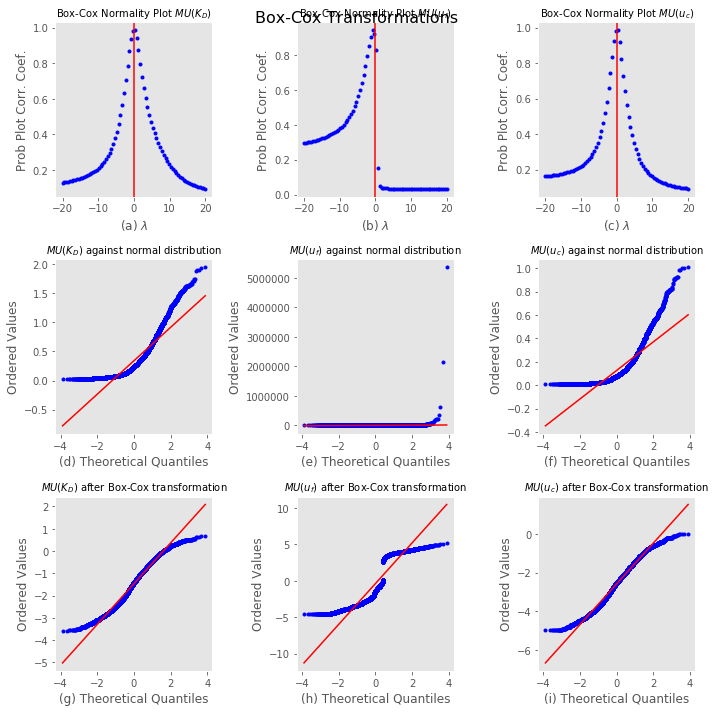

In [14]:
lambda_box_cox_def = None


plt.style.use('ggplot')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(331)
prob = stats.boxcox_normplot(KD_Var_data, -20, 20, plot=ax)
ax.set_title('Box-Cox Normality Plot $MU(K_D)$',size='10')

_, maxlog_KD = stats.boxcox(KD_Var_data)
ax.axvline(maxlog_KD, color='r')
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_color('blue')
ax.set_xlabel('(a) $\lambda$')
plt.grid()


ax1 = fig.add_subplot(334)
prob = stats.probplot(KD_Var_data, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.get_lines()[0].set_marker('.')
ax1.get_lines()[0].set_color('blue')
ax1.set_title('$MU(K_D)$ against normal distribution',size='10')
ax1.set_xlabel('(d) Theoretical Quantiles')
plt.grid()

ax2 = fig.add_subplot(337)
if lambda_box_cox_def == None:
    KD_boxcox, KD_lambda_box_cox = stats.boxcox(KD_Var_data,lmbda=lambda_box_cox_def)
else:
    KD_boxcox = stats.boxcox(KD_Var_data,lmbda=lambda_box_cox_def)
prob = stats.probplot(KD_boxcox, dist=stats.norm, plot=ax2)
ax2.set_title('$MU(K_D)$ after Box-Cox transformation',size='10')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_color('blue')
ax2.set_xlabel('(g) Theoretical Quantiles')
plt.grid()

ax = fig.add_subplot(332)
prob = stats.boxcox_normplot(uf_Var_data, -20, 20, plot=ax)
ax.set_title('Box-Cox Normality Plot $MU(u_f)$',size='10')
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_color('blue')
_, maxlog_uf = stats.boxcox(uf_Var_data)
ax.axvline(maxlog_uf, color='r')
ax.set_xlabel('(b) $\lambda$')
plt.grid()


ax1 = fig.add_subplot(335)
prob = stats.probplot(uf_Var_data, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.get_lines()[0].set_marker('.')
ax1.get_lines()[0].set_color('blue')
ax1.set_title('$MU(u_f)$ against normal distribution',size='10')
ax1.set_xlabel('(e) Theoretical Quantiles')
plt.grid()

ax2 = fig.add_subplot(338)
if lambda_box_cox_def == None:
    uf_boxcox, uf_lambda_box_cox = stats.boxcox(uf_Var_data,lmbda=lambda_box_cox_def)
else:
    uf_boxcox = stats.boxcox(uf_Var_data,lmbda=lambda_box_cox_def)
prob = stats.probplot(uf_boxcox, dist=stats.norm, plot=ax2)
ax2.set_title('$MU(u_f)$ after Box-Cox transformation',size='10')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_color('blue')
ax2.set_xlabel('(h) Theoretical Quantiles')
plt.grid()


ax = fig.add_subplot(333)
prob = stats.boxcox_normplot(uc_Var_data, -20, 20, plot=ax)
ax.set_title('Box-Cox Normality Plot $MU(u_c)$',size='10')

_, maxlog_uc = stats.boxcox(uc_Var_data)
ax.axvline(maxlog_uc, color='r')
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_color('blue')
ax.set_xlabel('(c) $\lambda$')
plt.grid()


ax1 = fig.add_subplot(336)
prob = stats.probplot(uc_Var_data, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.get_lines()[0].set_marker('.')
ax1.get_lines()[0].set_color('blue')
ax1.set_title('$MU(u_c)$ against normal distribution',size='10')
ax1.set_xlabel('(f) Theoretical Quantiles')
plt.grid()

ax2 = fig.add_subplot(339)
if lambda_box_cox_def == None:
    uc_boxcox, uc_lambda_box_cox = stats.boxcox(uc_Var_data,lmbda=lambda_box_cox_def)
else:
    uc_boxcox = stats.boxcox(uc_Var_data,lmbda=lambda_box_cox_def)
prob = stats.probplot(uc_boxcox, dist=stats.norm, plot=ax2)
ax2.set_title('$MU(u_c)$ after Box-Cox transformation',size='10')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_color('blue')
ax2.set_xlabel('(i) Theoretical Quantiles')
plt.grid()

plt.suptitle('Box-Cox Transformations',size='16')

plt.tight_layout()

plt.savefig('Box_Cox_Transformation_lambda_def.pdf')

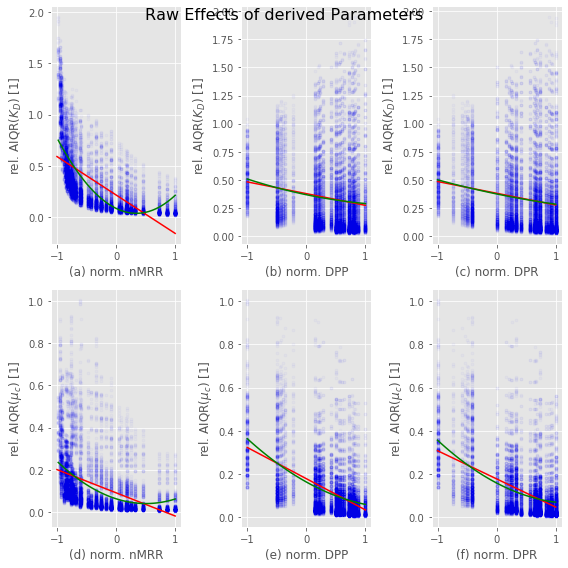

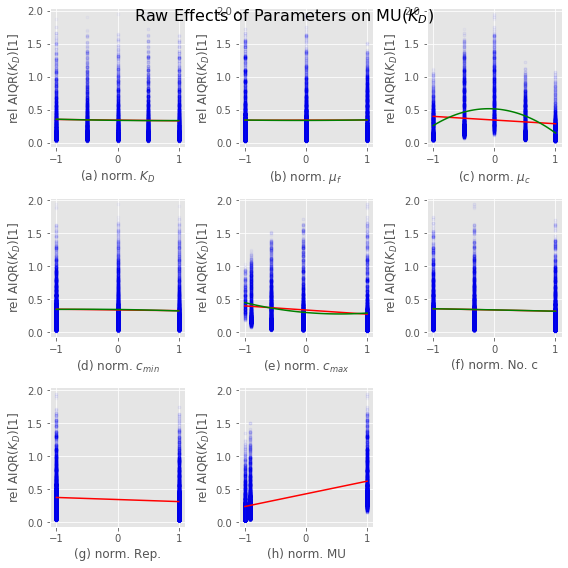

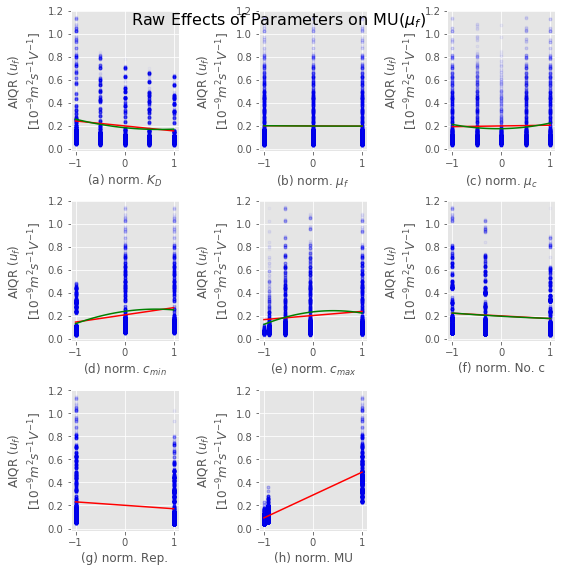

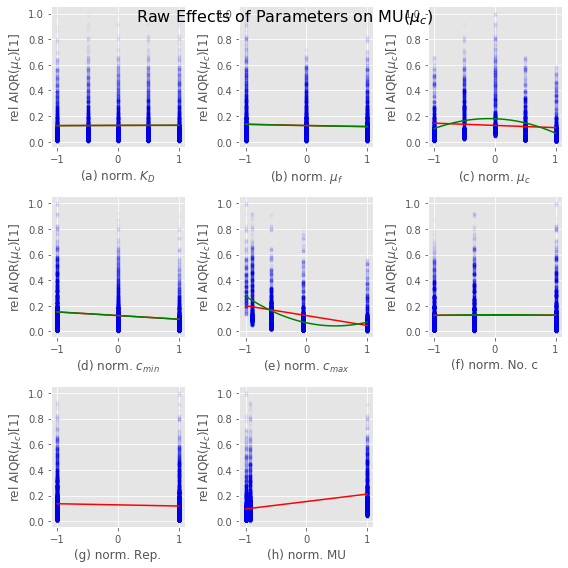

In [15]:

plot_key_list = ['nMRR_norm','DPP_norm','DPR_norm']
plot_key_list_names = ['norm. nMRR', 'norm. DPP', 'norm. DPR']
plot_param_list = ['KD rel AIQR','uc rel AIQR']
plot_param_list_names = ['rel. AIQR($K_D$) [1]','rel. AIQR($µ_c$) [1]']

plt.style.use('ggplot')
plot_raw_effects(specified_DF,plot_param_list,plot_key_list,
                     suptitle = 'Raw Effects of derived Parameters\n', save_name='Raw_effects_derived_parameter')

plot_key_list = ['KD_norm_m', 'uf_norm_m', 'uc_norm_m', 'c_min_norm_m', 'c_max_norm_m','no_c_norm_m', 'rep_norm_m','MU_norm']
plot_key_list_names = ['norm. $K_D$', 'norm. $µ_f$', 'norm. $µ_c$', 'norm. $c_{min}$','norm. $c_{max}$', 'norm. No. c', 'norm. Rep.','norm. MU']

plot_param_list = ['KD rel AIQR']
plot_param_list_names = ['rel AIQR($K_D$)[1]']

plot_raw_effects(specified_DF,plot_param_list,plot_key_list,
                     suptitle = 'Raw Effects of Parameters on MU($K_D$)\n', save_name='Raw_effects_DS_PS_KD')

plot_param_list = ['uf AIQR']
plot_param_list_names = ['AIQR ($u_f$) \n$[10^{-9} m^2 s^{-1} V^{-1}]$']

plot_raw_effects(specified_DF,plot_param_list,plot_key_list,
                     suptitle = 'Raw Effects of Parameters on MU($µ_f$)\n', save_name='Raw_effects_DS_PS_uf')

plot_param_list = ['uc rel AIQR']
plot_param_list_names = ['rel AIQR($µ_c$)[1]']

plot_raw_effects(specified_DF,plot_param_list,plot_key_list,
                     suptitle = 'Raw Effects of Parameters on MU($µ_c$)\n', save_name='Raw_effects_DS_PS_uc')

In [16]:
Y_dict = {'KD_Var_data':KD_Var_data, 'KD_Var_data_boxcox':KD_Var_data_boxcox, 'uf_Var_data': uf_Var_data, 'uf_Var_data_boxcox':uf_Var_data_boxcox,
         'uc_Var_data': uc_Var_data, 'uc_Var_data_boxcox':uc_Var_data_boxcox, 'relative_fails':specified_DF['rel fails']}
Y_DF = pd.DataFrame(Y_dict)

Y_param = 'KD'
Y_trans = '_boxcox'


Y_def = f'{Y_param}_Var_data{Y_trans}'

Y_descriptor = Y_def[0:2]
Y_descriptor_file = Y_def
print(Y_descriptor)


batch_number = np.random.randint(10**4)

if Y_param == 'KD':
    lambda_in = Lambda_list[0]
elif  Y_param == 'uf':
    lambda_in = Lambda_list[1]
else:
    lambda_in = Lambda_list[2]
    
    
Y = Y_DF[Y_def].values
X = PLS_dict_DF.values[:,:]

complete_DF = pd.concat([PLS_dict_DF, Y_DF], axis=1)

print(X.shape,Y.shape)
Summary_dict = {'Y def': Y_def, 'Y_descriptor_txt':Y_descriptor, 'Y_descriptor_file':Y_descriptor_file,
               'batch_number': Y_descriptor_file, 'labda_in': lambda_in}

KD
(13779, 27) (13779,)


In [17]:
PLS_dict_DF

,nMRR,NoDP,DPR,DPP,c_max,MU,nMRR2,nMRR_NoDP,nMRR_DPR,nMRR_DPP,...,DPR2,DPR_DPP,DPR_c_max,DPR_MU,DPP2,DPP_c_max,DPP_MU,c_max2,c_max_MU,MU2
0,0.182771,-0.333333,0.255197,0.201681,-0.578947,-1.000000,0.033405,-0.060924,0.046643,0.036861,...,0.065125,0.051468,-0.147746,-0.255197,0.040675,-0.116762,-0.201681,0.335180,0.578947,1.000000
1,-0.698498,-0.333333,0.887946,0.824047,1.000000,-0.923077,0.487899,0.232833,-0.620228,-0.575595,...,0.788448,0.731709,0.887946,-0.819642,0.679053,0.824047,-0.760659,1.000000,-0.923077,0.852071
2,0.455181,-1.000000,0.736842,0.500000,-0.052632,-1.000000,0.207190,-0.455181,0.335396,0.227590,...,0.542936,0.368421,-0.038781,-0.736842,0.250000,-0.026316,-0.500000,0.002770,0.052632,1.000000
3,-0.498253,1.000000,0.624788,0.596774,-0.052632,-1.000000,0.248256,-0.498253,-0.311302,-0.297344,...,0.390360,0.372857,-0.032884,-0.624788,0.356139,-0.031409,-0.596774,0.002770,0.052632,1.000000
4,-0.849249,-1.000000,0.624788,0.596774,-0.052632,1.000000,0.721224,0.849249,-0.530600,-0.506810,...,0.390360,0.372857,-0.032884,0.624788,0.356139,-0.031409,0.596774,0.002770,-0.052632,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13774,-0.267781,0.111111,0.323308,0.142857,-0.578947,-0.923077,0.071706,-0.029753,-0.086576,-0.038254,...,0.104528,0.046187,-0.187178,-0.298438,0.020408,-0.082707,-0.131868,0.335180,0.534413,0.852071
13775,-0.440067,1.000000,-1.000000,-1.000000,-1.000000,-0.923077,0.193659,-0.440067,0.440067,0.440067,...,1.000000,1.000000,1.000000,0.923077,1.000000,1.000000,0.923077,1.000000,0.923077,0.852071
13776,-0.612354,1.000000,0.915276,0.800443,1.000000,-0.923077,0.374978,-0.612354,-0.560473,-0.490155,...,0.837730,0.732627,0.915276,-0.844870,0.640710,0.800443,-0.738871,1.000000,-0.923077,0.852071
13777,0.727590,1.000000,0.421053,0.772727,-0.052632,-1.000000,0.529388,0.727590,0.306354,0.562229,...,0.177285,0.325359,-0.022161,-0.421053,0.597107,-0.040670,-0.772727,0.002770,0.052632,1.000000




Start evaluating the optimal number of PLS-components before variable selection.
Max. tested PLS-components: 17 with no_of_tests repetitions each.


The optimal number of PLS-components is: 17.




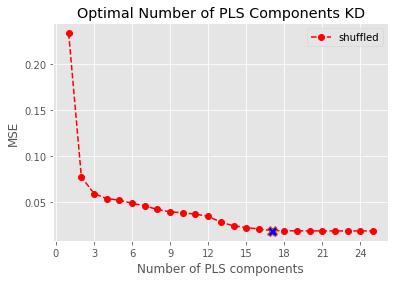

In [18]:
no_of_tests = 100
title_in_2 = f'Optimal Number of PLS Components {Y_descriptor}'
savename_in_comp_plot = f'{batch_number}_No_PLS_comp_{Y_descriptor_file}_pre_red.pdf'
print('\n\nStart evaluating the optimal number of PLS-components before variable selection.')
no_comp_sh_list = []
excl_fig_list = {}
for i in range(no_of_tests):
    no_comp_sh,fig,Deriv_sh,opt_deriv_sh = find_opt_no_comp(X,Y,Opt_parameter = 'MSE',
                         min_comp_in = None,max_comp_in = None,
                         title_in = title_in_2,savename_in = None,
                         splits_in = 5,show_plot_in = False,shuffle_in_2=True,Deriv_threshold= 0.01,p_in= 0.75)
    if not no_comp_sh in no_comp_sh_list:
        name_fig = f'{no_comp_sh}'
        excl_fig_list[name_fig]= fig
    no_comp_sh_list.append(no_comp_sh)
    print(f'{round(((100*(i+1))/no_of_tests),2)}%',end="\r")
instance_list = []
comp_list = []
no_comp_sh_list.sort()
min_comp = np.min(no_comp_sh_list)
max_comp = np.max(no_comp_sh_list)
x_pos = 2
for i in range(min_comp,max_comp+1):
    comp_list.append(i)
    no_i = no_comp_sh_list.count(i)
    instance_list.append(no_i)
    x_pos += no_i
plt.ylim(min_comp-0.5,max_comp+0.5)
plt.xlim(0-len(no_comp_sh_list)*0.1,len(no_comp_sh_list)*1.1)
best_comp = comp_list[np.argmax(instance_list)]
print(f'Max. tested PLS-components: {max_comp} with no_of_tests repetitions each.\n')
print(f'\nThe optimal number of PLS-components is: {best_comp}.\n\n')
plt.close()
Fig = excl_fig_list[f'{best_comp}']
Fig.savefig(savename_in_comp_plot)
Fig

In [19]:
PLS_reg_func = PLSRegression(n_components=best_comp,max_iter=500, tol=1e-06, copy=True,scale=True)

Summary_dict['best no comp pre']= best_comp
PLS_reg_func.fit(X,Y)
PLS_coefs = PLS_reg_func.coef_
print('Start PLS-R before variable selection\n')
print('Fit parameter:')
print(PLS_reg_func.get_params(deep = True))
print('\nPLS $R^2$')
print(PLS_reg_func.score(X,Y))
Reg_model = PLS_reg_func.predict(X)
Residuals = [float(x-y) for x,y in zip (Y,Reg_model)]
SE = [float(x-y)**2 for x,y in zip (Y,Reg_model)]
RSS = np.sum(SE)
number_measurements = len(Y)
number_coefficients = len(PLS_coefs)
df_fit = number_measurements-number_coefficients
RSS_red = RSS/df_fit
RMSE_red = np.sqrt(RSS_red)
print('\nPLS coef shape and list:')
print(f'PLS coef shape: {PLS_coefs.shape}\n')
print(PLS_coefs)
Summary_dict['PLS coef pre']= [PLS_coefs]

Start PLS-R before variable selection

Fit parameter:
{'copy': True, 'max_iter': 500, 'n_components': 17, 'scale': True, 'tol': 1e-06}

PLS $R^2$
0.9785334343911094

PLS coef shape and list:
PLS coef shape: (27, 1)

[[-1.57125112e+00]
 [-1.94630002e-01]
 [-3.69950017e-01]
 [-3.67012115e-02]
 [-1.68905903e-01]
 [-1.10577438e+00]
 [ 2.44530366e-01]
 [ 6.72851775e-04]
 [-4.10979098e-02]
 [ 7.61382789e-03]
 [ 2.02197155e-02]
 [-1.07784154e+00]
 [ 4.60535439e-02]
 [-2.88388410e-02]
 [ 3.57044042e-02]
 [-4.17840214e-03]
 [ 3.45403398e-03]
 [ 1.54945093e-01]
 [-9.17045586e-02]
 [-1.81984505e-02]
 [-7.44833580e-02]
 [ 1.20129421e-01]
 [-6.17533290e-03]
 [-2.48202319e-02]
 [ 6.45187967e-02]
 [ 6.02184343e-02]
 [-3.60026815e-02]]


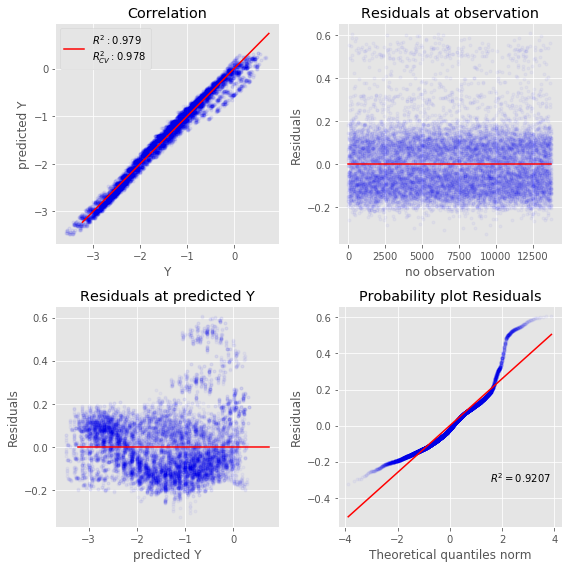

In [20]:
Reg_model = PLS_reg_func.predict(X)
save_name_in = f'{batch_number}_statistics_pre_elimination_{Y_descriptor_file}.pdf'
plt.style.use('ggplot')
Stats_Model(Y,Reg_model, X, PLS_reg_func, savename=save_name_in)

In [21]:
# Variable selection criteria
# Definition of alpha for variable significance and VIP cut off
alpha_coef = 0.05
VIP_Cut_OFF = 0.8
select_variables = 'VIP'
Significance_flag = True


sig_dict = {'beta': x_labels_2}
coef_list = [PLS_coefs[a][0] for a in range(len(PLS_coefs))]
sig_dict['coef'] = coef_list
bool_t_beta_list = [True for __ in range(len(coef_list))]
if Significance_flag:
    SD_jackknife = jackKnifeSD(X,Y,PLS_reg_func,len(X),totalSet=False)
    SD_jackknife = [SD_jackknife[a][0] for a in range(len(SD_jackknife))]
    t_crit = stats.t.ppf(q=1-alpha_coef/2.,df=df_fit)
    T_beta = [abs(PLS_coefs[a][0]/SD_jackknife[a]) for a in range(len(SD_jackknife))]
    p_value_t_beta_list = [2*(1 - t.cdf(a, df_fit)) for a in T_beta]
    bool_t_beta_list = [a>t_crit for a in T_beta]
    sig_dict['SE_beta'] = SD_jackknife
    sig_dict['t-value'] = T_beta
    sig_dict['p-value'] = p_value_t_beta_list
    sig_dict['significance > critical value'] = bool_t_beta_list
VIPS = VIP_function(PLS_reg_func)
sig_dict['VIP'] = VIPS
sig_df = pd.DataFrame(sig_dict)

Start Jack-Knifing the Variance with 13779 splits in a (13779, 27) X matrix.



In [22]:
sig_df

,beta,coef,SE_beta,t-value,p-value,significance > critical value,VIP
0,$nMRR$,-1.571251,0.014391,109.185410,0.000000e+00,True,2.310012
1,$noDP$,-0.194630,0.008101,24.025980,0.000000e+00,True,0.590253
2,$DPR$,-0.369950,0.011944,30.973661,0.000000e+00,True,0.866040
3,$DPP$,-0.036701,0.010976,3.343666,8.289990e-04,True,0.799885
4,$cmax$,-0.168906,0.003913,43.164900,0.000000e+00,True,0.663601
5,$MU$,-1.105774,0.015144,73.017197,0.000000e+00,True,1.543493
6,$nMRR^2$,0.244530,0.002442,100.148360,0.000000e+00,True,1.595018
7,$nMRR \cdot noDP$,0.000673,0.002930,0.229644,8.183716e-01,False,0.782664
8,$nMRR \cdot DPR$,-0.041098,0.011544,3.560010,3.720918e-04,True,1.314543
9,$nMRR \cdot DPP$,0.007614,0.011087,0.686711,4.922767e-01,False,1.347056


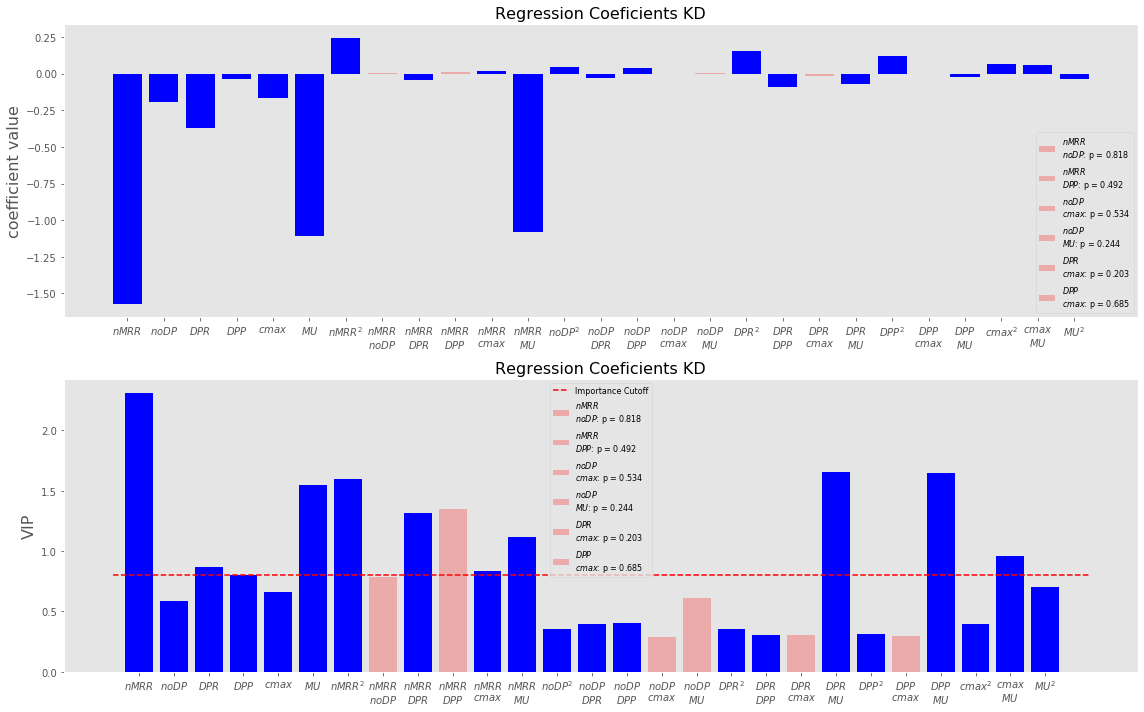

In [23]:
PLS_coefs_list = [x[0] for x in PLS_coefs]

save_name_in = f'{batch_number}_Abs_Coef_and_VIPS_pre_elimination_{Y_descriptor_file}.pdf'
title_in = f'Regression Coeficients {Y_descriptor}'

y_labels = ['coefficient value','VIP']
x_plot_list = [PLS_coefs_list,VIPS]

bar_numbers = range(len(PLS_coefs))
plt.style.use('ggplot')
plt.figure(figsize=(16, 10))
for plot_i in range(2):
    plt.subplot(2,1,plot_i+1)
    for i in range(len(bar_numbers)):
        if bool_t_beta_list[i]:
            plt.bar(bar_numbers[i],x_plot_list[plot_i][i],tick_label=x_labels[i],color='b')
        else:
            plt.bar(bar_numbers[i],x_plot_list[plot_i][i],tick_label=x_labels[i],color='r',
                    alpha=0.25,label=f'{x_labels[i]}: p = {round(p_value_t_beta_list[i],3)} ')
            plt.legend(prop={'size': 8})
    plt.xticks(bar_numbers,x_labels)
    plt.title(title_in,size='16')
    plt.ylabel(y_labels[plot_i],size='16')
    plt.grid()

plt.plot([-0.75,len(x_labels)+0.25],[VIP_Cut_OFF,VIP_Cut_OFF],'r--',label='Importance Cutoff')
plt.legend(prop={'size': 8})
plt.tight_layout()

plt.savefig(save_name_in)





In [24]:
# Variable selection
consider_relations = True

total = 0
for k in range(len(x_labels)):
    if not('^2' in x_labels[k] or '\n' in x_labels[k]):
        total +=1
relation_list = []
for j in range(total):
    inner_relation_list = []
    for i in range(len(x_labels)-total):
        test_index = i+total
        if x_labels[j][1:-1] in x_labels[test_index]:
            inner_relation_list.append(test_index)
    
    relation_list.append(inner_relation_list)
drop_coef_list = []
if select_variables == 'VIP':
    for VIP in VIPS:
        drop_coef_list.append(bool(VIP<VIP_Cut_OFF))       
else: 
    drop_coef_list = [not x for x in bool_t_beta_list]
Summary_dict['Relation considerd']= consider_relations

if consider_relations:
    for i in range(len(relation_list)):
        for j in range(len(relation_list)):
            if not drop_coef_list[relation_list[i][j]]:
                drop_coef_list[i] = False
                break

PLS_dict_DF_red = PLS_dict_DF[:]
keys = PLS_dict_DF_red.keys()
drop_keys = list(keys[drop_coef_list])
print(f'The keys: {drop_keys} were dropped.')
PLS_dict_DF_red = PLS_dict_DF_red.drop(axis=1, labels= drop_keys)
X_red = PLS_dict_DF_red.values[:,:]
PLS_dict_DF_red.head()

The keys: ['NoDP', 'nMRR_NoDP', 'NoDP2', 'NoDP_DPR', 'NoDP_DPP', 'NoDP_c_max', 'NoDP_MU', 'DPR2', 'DPR_DPP', 'DPR_c_max', 'DPP2', 'DPP_c_max', 'c_max2', 'MU2'] were dropped.


,nMRR,DPR,DPP,c_max,MU,nMRR2,nMRR_DPR,nMRR_DPP,nMRR_c_max,nMRR_MU,DPR_MU,DPP_MU,c_max_MU
0,0.182771,0.255197,0.201681,-0.578947,-1.000000,0.033405,0.046643,0.036861,-0.105815,-0.182771,-0.255197,-0.201681,0.578947
1,-0.698498,0.887946,0.824047,1.000000,-0.923077,0.487899,-0.620228,-0.575595,-0.698498,0.644767,-0.819642,-0.760659,-0.923077
2,0.455181,0.736842,0.500000,-0.052632,-1.000000,0.207190,0.335396,0.227590,-0.023957,-0.455181,-0.736842,-0.500000,0.052632
3,-0.498253,0.624788,0.596774,-0.052632,-1.000000,0.248256,-0.311302,-0.297344,0.026224,0.498253,-0.624788,-0.596774,0.052632
4,-0.849249,0.624788,0.596774,-0.052632,1.000000,0.721224,-0.530600,-0.506810,0.044697,-0.849249,0.624788,0.596774,-0.052632


100.0%
10


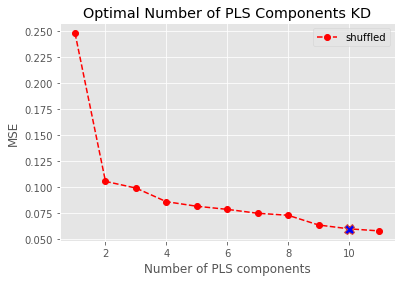

In [25]:

savename_in_comp_plot = f'{batch_number}_No_PLS_comp_{Y_descriptor_file}_after_red.pdf'
no_comp_sh_list = []
excl_fig_list = {}
for i in range(no_of_tests):
    no_comp_sh,fig,Deriv_sh,opt_deriv_sh = find_opt_no_comp(X_red,Y,Opt_parameter = 'MSE',
                         min_comp_in = None,max_comp_in = None,
                         title_in = title_in_2,savename_in = None,
                         splits_in = 5,show_plot_in = False,shuffle_in_2=True)
    if not no_comp_sh in no_comp_sh_list:
        name_fig = f'{no_comp_sh}'
        excl_fig_list[name_fig]= fig
    no_comp_sh_list.append(no_comp_sh)
    print(f'{((100*(i+1))/no_of_tests)}%',end="\r")
no_comp_sh_list.sort()
min_comp = np.min(no_comp_sh_list)
max_comp = np.max(no_comp_sh_list)
instance_list = []
comp_list = []
x_pos = 2
for i in range(min_comp,max_comp+1):
    comp_list.append(i)
    no_i = no_comp_sh_list.count(i)
    instance_list.append(no_i)
    x_pos += no_i
best_comp_red = comp_list[np.argmax(instance_list)]
print('')
print(best_comp_red)

Fig = excl_fig_list[f'{best_comp_red}']
Fig.savefig(savename_in_comp_plot)
Fig


In [26]:
PLS_reg_func_red = PLSRegression(n_components=best_comp_red,max_iter=500, tol=1e-06, copy=True,scale=True)
print('PLS regression after variable selection\n')
Summary_dict['best no comp after']= best_comp_red
PLS_reg_func_red.fit(X_red,Y)
print(f'$R^2$: {PLS_reg_func_red.score(X_red,Y)}')
PLS_coefs_red = PLS_reg_func_red.coef_
print(f'PLS coefficients \nshape: {PLS_coefs_red.shape}\ncoefs:')
print(PLS_coefs_red)
Summary_dict['PLS coef after']= [PLS_coefs_red]

PLS regression after variable selection

$R^2$: 0.9296910894380315
PLS coefficients 
shape: (13, 1)
coefs:
[[-1.33615979]
 [-0.43803735]
 [-0.22456802]
 [ 0.18854051]
 [-0.85095437]
 [ 0.23763084]
 [-0.09807374]
 [-0.01150787]
 [ 0.06118408]
 [-0.84929225]
 [-0.09083893]
 [-0.02799042]
 [ 0.08379663]]


In [27]:
keep_coef_list = [not x for x in drop_coef_list]
x_label_red = list(np.array(x_labels_2)[keep_coef_list])
sig_dict_red = {'beta': x_label_red}
coef_list_red = [PLS_coefs_red[a][0] for a in range(len(PLS_coefs_red))]
sig_dict_red['coef'] = coef_list_red
bool_t_beta_list_red = [True for __ in range(len(PLS_coefs_red))]
if Significance_flag:
    SD_jackknife_red = jackKnifeSD(X_red,Y,PLS_reg_func_red,len(X_red),totalSet=False)
    SD_jackknife_red = [SD_jackknife_red[a][0] for a in range(len(SD_jackknife_red))]
    T_beta_red = [abs(PLS_coefs_red[a][0]/SD_jackknife_red[a]) for a in range(len(SD_jackknife_red))]
    p_value_t_beta_list_red = [2*(1 - t.cdf(a, df_fit)) for a in T_beta_red]
    bool_t_beta_list_red = [a>t_crit for a in T_beta_red]
    sig_dict_red['SE_beta'] = SD_jackknife_red
    sig_dict_red['t-value'] = T_beta_red
    sig_dict_red['p-value'] = p_value_t_beta_list_red
    sig_dict_red['significance > critical value'] = bool_t_beta_list_red
VIPS_red = VIP_function(PLS_reg_func_red)
sig_dict_red['VIP'] = VIPS_red
sig_df_red = pd.DataFrame(sig_dict_red)

Start Jack-Knifing the Variance with 13779 splits in a (13779, 13) X matrix.



In [28]:
sig_df_red

,beta,coef,SE_beta,t-value,p-value,significance > critical value,VIP
0,$nMRR$,-1.336160,0.033818,39.510434,0.000000e+00,True,1.673274
1,$DPR$,-0.438037,0.016824,26.037204,0.000000e+00,True,0.693543
2,$DPP$,-0.224568,0.016376,13.713412,0.000000e+00,True,0.603644
3,$cmax$,0.188541,0.016482,11.438838,0.000000e+00,True,0.579290
4,$MU$,-0.850954,0.044429,19.153088,0.000000e+00,True,1.121294
5,$nMRR^2$,0.237631,0.003238,73.381624,0.000000e+00,True,1.145668
6,$nMRR \cdot DPR$,-0.098074,0.017929,5.470161,4.574851e-08,True,0.962517
7,$nMRR \cdot DPP$,-0.011508,0.014474,0.795096,4.265711e-01,False,0.980954
8,$nMRR \cdot cmax$,0.061184,0.013971,4.379235,1.199770e-05,True,0.709647
9,$nMRR \cdot MU$,-0.849292,0.031054,27.348579,0.000000e+00,True,0.815333


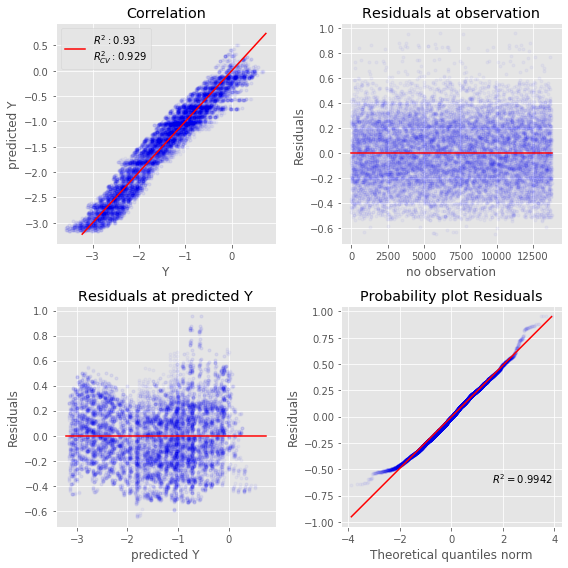

In [29]:
Reg_model_red = PLS_reg_func_red.predict(X_red)
save_name_in = f'{batch_number}_statistics_after_elimination_{Y_descriptor_file}.pdf'
plt.style.use('ggplot')
Stats_Model(Y,Reg_model_red,X_red, PLS_reg_func_red, savename=save_name_in)


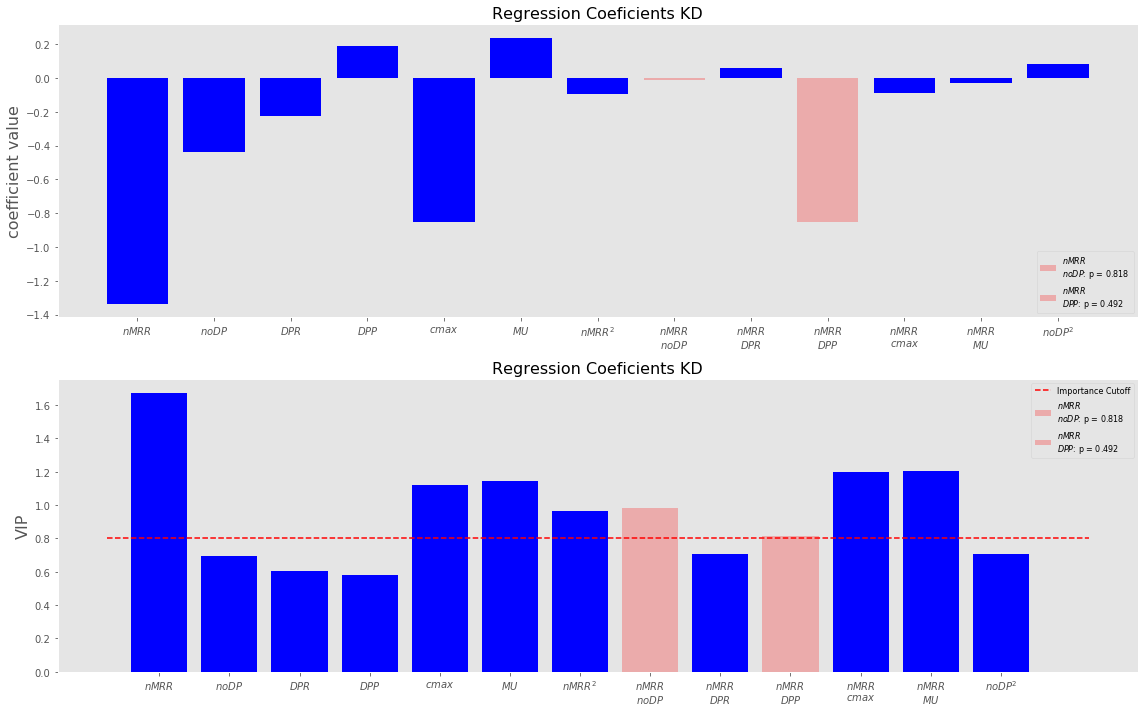

In [30]:
PLS_coefs_list_red = [x[0] for x in PLS_coefs_red]

save_name_in = f'{batch_number}_Abs_Coef_and_VIPS_after_elimination_{Y_descriptor_file}.pdf'
title_in = f'Regression Coeficients {Y_descriptor}'

y_labels = ['coefficient value','VIP']
x_plot_list = [PLS_coefs_list_red,VIPS_red]

bar_numbers = range(len(PLS_coefs_red))
plt.style.use('ggplot')
plt.figure(figsize=(16, 10))
for plot_i in range(2):
    plt.subplot(2,1,plot_i+1)
    for i in range(len(bar_numbers)):
        if bool_t_beta_list[i]:
            plt.bar(bar_numbers[i],x_plot_list[plot_i][i],tick_label=x_labels[i],color='b')
        else:
            plt.bar(bar_numbers[i],x_plot_list[plot_i][i],tick_label=x_labels[i],color='r',
                    alpha=0.25,label=f'{x_labels[i]}: p = {round(p_value_t_beta_list[i],3)} ')
            plt.legend(prop={'size': 8})
    plt.xticks(bar_numbers,x_labels)
    plt.title(title_in,size='16')
    plt.ylabel(y_labels[plot_i],size='16')
    plt.grid()

plt.plot([-0.75,len(x_label_red)+0.25],[VIP_Cut_OFF,VIP_Cut_OFF],'r--',label='Importance Cutoff')
plt.legend(prop={'size': 8})
plt.tight_layout()

plt.savefig(save_name_in)

In [31]:
save_name_in = f'{batch_number}_Summary_dict_{Y_descriptor_file}.csv'

Summary_dict_DF = pd.DataFrame(Summary_dict)
Summary_dict_DF.to_csv(save_name_in)

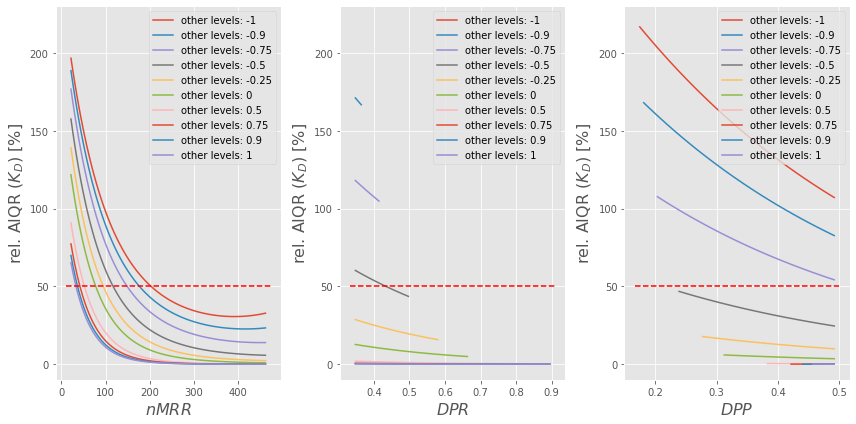

In [53]:
save_name_in = f'{batch_number}_main_effects_{Y_descriptor_file}.pdf'

other_level_list = [-1,-0.9,-0.75,-0.5,-0.25,0,0.5,0.75,0.9,1]
DPP_min = specified_DF['DPP'].min()
DPP_max = specified_DF['DPP'].max()
DPR_max= specified_DF['DPR'].max()
DPR_min = specified_DF['DPR'].min()
nMRR_max = specified_DF['nMRR'].max()
nMRR_min = specified_DF['nMRR'].min()
a_high_list = [nMRR_max,__, DPR_max,DPP_max,__,__]
a_low_list = [nMRR_min,__, DPR_min,DPP_min,__,__]
#[nMRR,NoDP,DPR,DPP,cmax,MU]

plt.figure(figsize=(12,6))

plot_number = 1

for selector in [0,2,3]:
    
    plt.subplot(1,3,plot_number)
    for other_level in other_level_list:

        input_range= np.linspace(-0.95,0.95,100)
        input_range_a = [((x+1)*(a_high_list[selector] -  a_low_list[selector])*1/2) +  a_low_list[selector] for x in input_range]
        X_test_list =[]
        for input_value in input_range:
            prediction_list = [other_level,other_level,other_level,other_level,other_level,other_level]
            prediction_list[selector] = input_value
            # prediction_list = [nMRR,noDP,DPR,DPP,cmax,MU]
            if selector == 2 or selector == 3:
                if selector == 2:
                    DPR_test_code = input_value
                    DPP_test_code = other_level
                elif selector == 3:
                    DPP_test_code = input_value
                    DPR_test_code = other_level
                DPR_test = ((DPR_test_code+1)*(DPR_max -  DPR_min)*1/2) +  DPR_min
                DPP_test = ((DPP_test_code+1)*(DPP_max -  DPP_min)*1/2) +  DPP_min
                if DPR_test > 2* DPP_test:
                     X_test_list.append(np.nan)
                else:
                    X_test = 100* predict_Response(prediction_list, PLS_reg_func_red,lambda_in,drop_coef_list)
                    X_test_list.append(X_test)
            else:
                    X_test = 100* predict_Response(prediction_list, PLS_reg_func_red,lambda_in,drop_coef_list)
                    X_test_list.append(X_test)

        plt.plot(input_range_a,X_test_list,label=f'other levels: {other_level}')
    plt.plot([a_low_list[selector], a_high_list[selector]],[50,50],'r--')
    plt.legend()
    plt.ylim(-10,230)
    plt.xlabel(f'{x_labels[selector]}',size=16)
    plt.ylabel('rel. AIQR ($K_D$) [%]',size=16)
    plot_number +=1

#plt.suptitle('Overview Main Effects',size=18)
plt.tight_layout()
plt.savefig(save_name_in)

C:\Users\49151\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


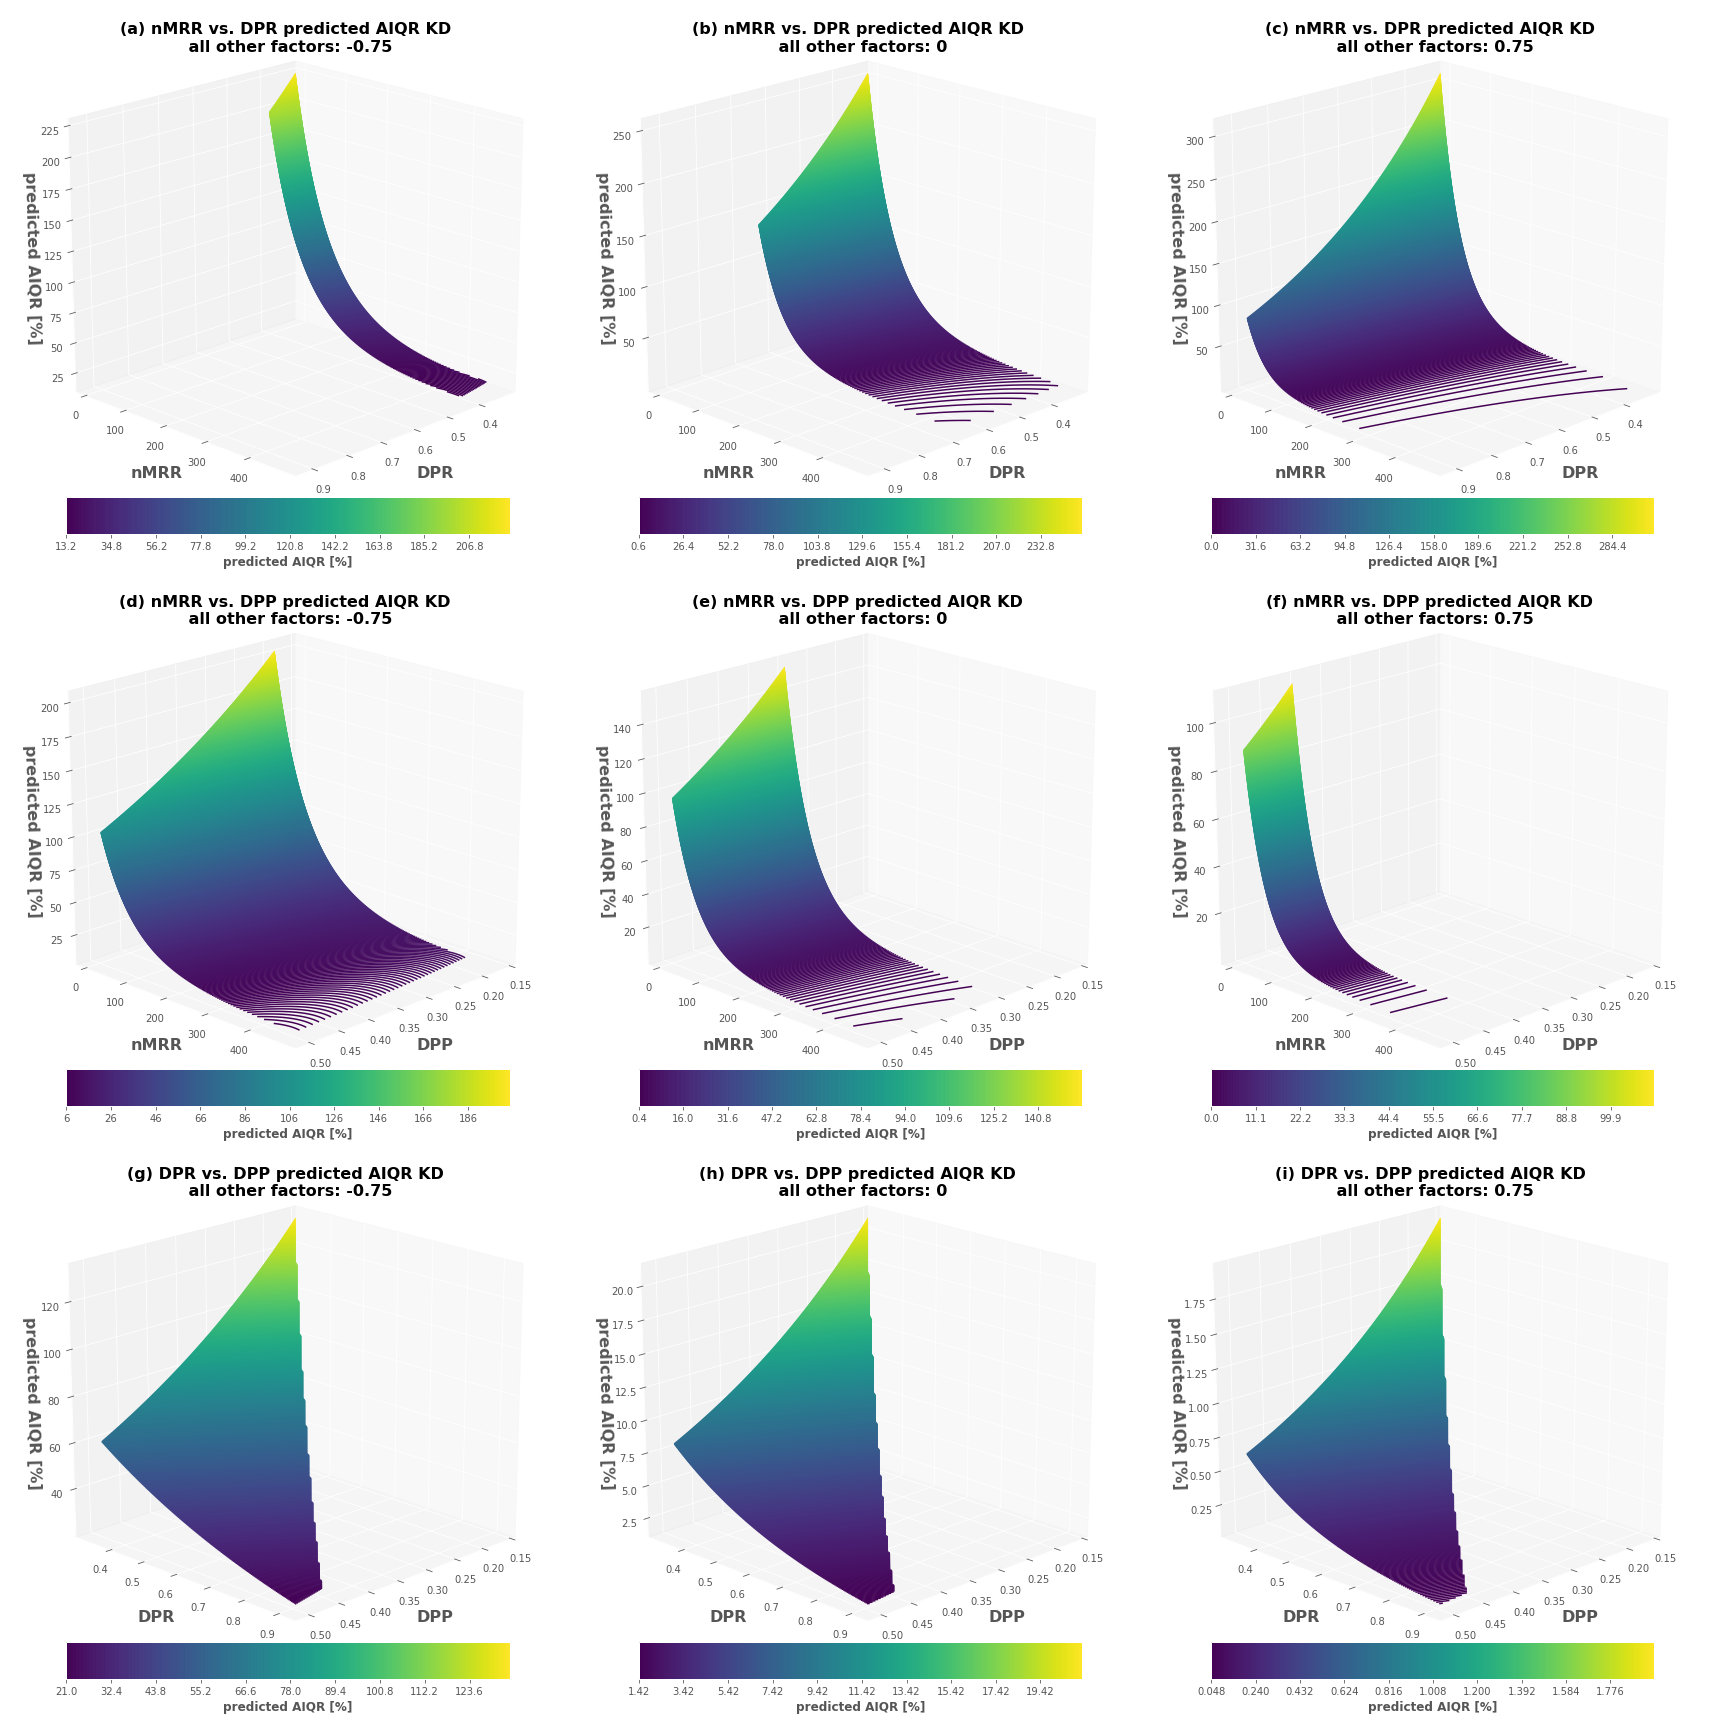

In [60]:

save_name = f'{batch_number}_complete_{Y_descriptor_file}_lvl.pdf'
fir_cont_sel = 3
sec_cont_sel = 4
other_level_list = [-0.75,0,0.75]

cont_plot_res = 1000

#[nMRR,NoDP,DPR,DPP,cmax,MU]
var_names = ['nMRR','NoDP','DPR','DPP','cmax','MU']

DPP_min = specified_DF['DPP'].min()
DPP_max = specified_DF['DPP'].max()
DPR_max = specified_DF['DPR'].max()
DPR_min = specified_DF['DPR'].min()
nMRR_max = specified_DF['nMRR'].max()
nMRR_min = specified_DF['nMRR'].min()

sub_fig_num=1
fig = plt.figure(figsize=(24,24))

selector_list = [[0,2],[0,3],[2,3]]
sub_label_list = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
for selector_list_i in selector_list:
    fir_cont_sel = selector_list_i[0]
    sec_cont_sel = selector_list_i[1]
    
    var_max_list = [nMRR_max,__,DPR_max,DPP_max,__,__]
    var_min_list = [nMRR_min,__,DPR_min,DPP_min,__,__]
    var_a_max = var_max_list[fir_cont_sel]
    var_b_max = var_max_list[sec_cont_sel]
    var_a_min = var_min_list[fir_cont_sel]
    var_b_min = var_min_list[sec_cont_sel]
    var_a = var_names[fir_cont_sel]
    var_b = var_names[sec_cont_sel]
    
    for other_level in other_level_list:
        sub_label_i = sub_label_list[sub_fig_num-1]
        fir_cont_list,sec_cont_list,Y_pred_list = [],[],[]
        input_range= np.linspace(-1,1,100)
        DPR_test_code,DPP_test_code = other_level,other_level
        eval_list = [other_level,other_level,other_level,other_level,other_level,other_level]
        for fir_cont in input_range:
            fir_cont_list.append(fir_cont)
            Y_pred_list_inner = []
            if fir_cont_sel == 3:
                DPP_test_code = fir_cont
            elif fir_cont_sel == 2:
                DPR_test_code = fir_cont
            for sec_cont in input_range:
                if sec_cont_sel == 3:
                    DPP_test_code = sec_cont
                elif sec_cont_sel == 2:
                    DPR_test_code = sec_cont
                    
                DPR_test = ((DPR_test_code+1)*(DPR_max -  DPR_min)*1/2) +  DPR_min
                DPP_test = ((DPP_test_code+1)*(DPP_max -  DPP_min)*1/2) +  DPP_min
                if DPR_test > 2* DPP_test:
                    Y_pred_list_inner.append(np.nan)
                else:
                    eval_list[fir_cont_sel] = fir_cont
                    eval_list[sec_cont_sel] = sec_cont
                    Y_pred = 100*predict_Response(eval_list, PLS_reg_func_red,lambda_in,drop_coef_list)
                    Y_pred_list_inner.append(Y_pred)
            Y_pred_list.append(Y_pred_list_inner)
        sec_cont_list = [sec_cont_list]
        Y_mesh_self = np.array(Y_pred_list)
        level_str = str(other_level)
        level_str = level_str.replace('.','_')
        title_in = f'{sub_label_i} {var_a} vs. {var_b} predicted AIQR {Y_descriptor} \n all other factors: {other_level}'
        a_high,a_low = var_a_max, var_a_min
        b_high,b_low = var_b_max, var_b_min 
        input_range_a = [((x+1)*(a_high - a_low)*1/2) + a_low  for x in input_range]
        input_range_b = [((x+1)*(b_high - b_low)*1/2) + b_low for x in input_range]

        ax = fig.add_subplot(3,3,sub_fig_num,projection='3d')

        #ig = plt.figure(figsize=(6,6))
        #ax = plt.axes(projection='3d')
        Cont_plot = ax.contour3D(input_range_b, input_range_a, Y_mesh_self,cont_plot_res,cmap='viridis')
        ax.set_xlabel(f'{var_b}',fontweight='bold',size=16,labelpad=10)
        ax.set_ylabel(f'{var_a}',fontweight='bold',size=16,labelpad=10)
        ax.set_zlabel('predicted AIQR [%]',fontweight='bold',size=16)
        ax.set_title(title_in,size=16,fontweight='bold',y=1,pad=-3)
        colorbar = plt.colorbar(Cont_plot,shrink=1, aspect=12,orientation="horizontal",fraction=0.07,anchor=(1.0,0.0),pad=-0.05,)
        colorbar.set_label('predicted AIQR [%]',fontweight='bold')
        ax.set_facecolor('w')
        plt.style.use('ggplot')
        ax.view_init(20, 45)
        sub_fig_num +=1

plt.tight_layout()


plt.savefig(save_name)

